In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#set plot style 
plt.style.use(style  = 'ggplot')
plt.rcParams['figure.figsize'] = (10,6)

## Exploration

In [3]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)
#test data doesnt include the final sale price information. 

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [4]:
#orginal data

## Univariate Analysis



In [5]:
from scipy.stats import norm
from scipy import stats

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
skew = train.SalePrice.skew()
print('Target skew is:', skew ) #target is highly skewed to the right

Target skew is: 1.8828757597682129


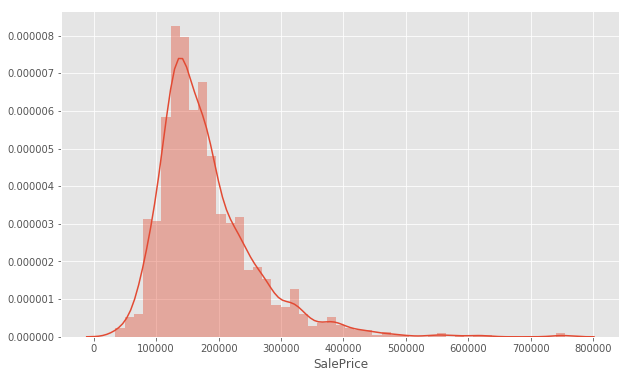

In [8]:
sns.distplot(train.SalePrice)

In [9]:
target = np.log(train.SalePrice) #log transform the variable
print("Skew is: ", target.skew())

Skew is:  0.12133506220520406


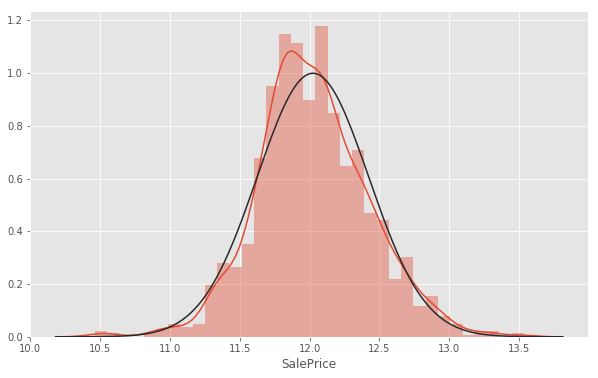

In [10]:
sns.distplot(target, fit = norm) #contrast with normal distritbution

In [11]:
target = train[['SalePrice']]#array of salprice

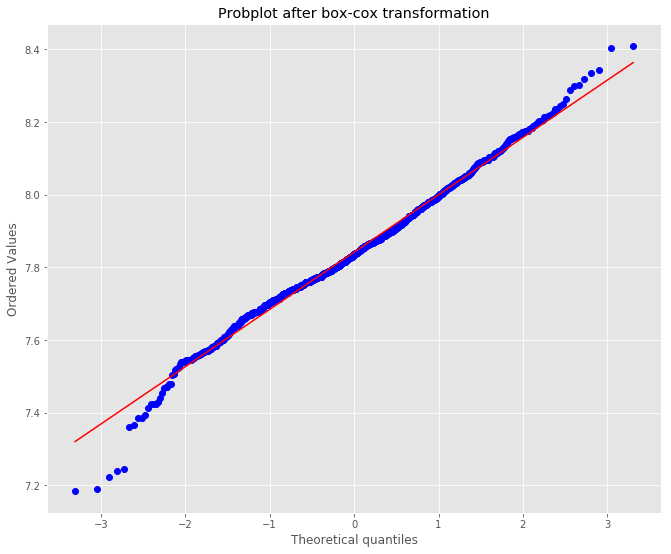

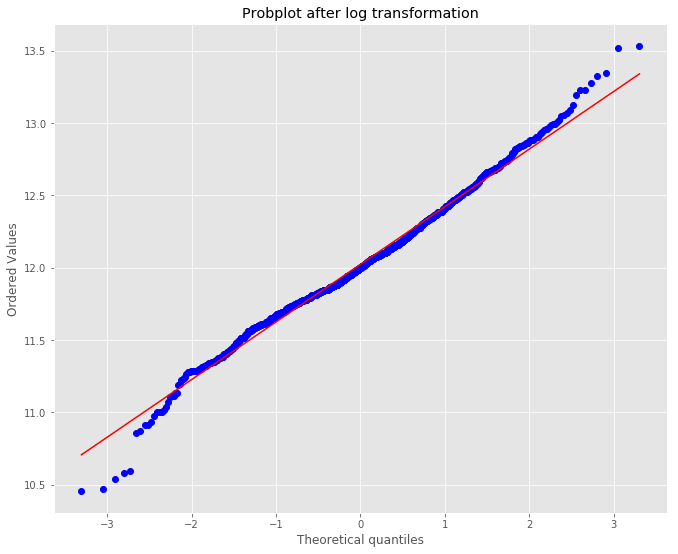

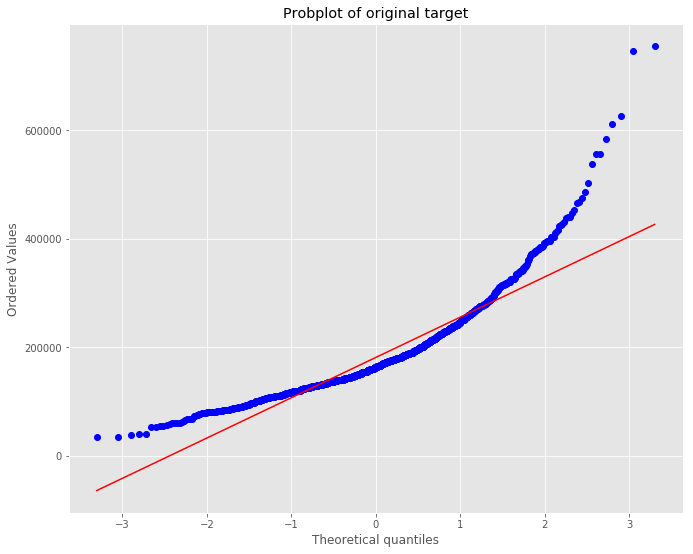

In [12]:
#Compare normalit of target under box-cox and log
fig1, ax1 = plt.subplots(figsize = (11,9))
saleprice_bc, lmbda = stats.boxcox(target)
saleprice_bc.flatten()#make it 1 dimensional 
prob1 = stats.probplot(saleprice_bc.flatten(), dist = stats.norm, plot = ax1)
ax1.set_title('Probplot after box-cox transformation')


#try log transforamtion
fig2, ax2 = plt.subplots(figsize = (11,9))
saleprice_log= stats.boxcox(target, lmbda = 0) #log transform

prob2 = stats.probplot(saleprice_log.flatten(), dist = stats.norm, plot = ax2)
ax2.set_title('Probplot after log transformation')

fig3, ax3 = plt.subplots(figsize = (11,9))

prob3 = stats.probplot(train.SalePrice, dist = stats.norm, plot = ax3)
ax3.set_title('Probplot of original target')
plt.show()

In [13]:
sp.stats.skew(saleprice_bc)

array([-0.00864409])

In [14]:
sp.stats.skew(saleprice_log)

array([0.12121037])

##### we should go with log transform 

In [15]:
target = np.log(train['SalePrice'])

## Bivariate Analysis

We should see which features are highly correlated with the target and investigate them for outliers and linear relationship. 

In [110]:
corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

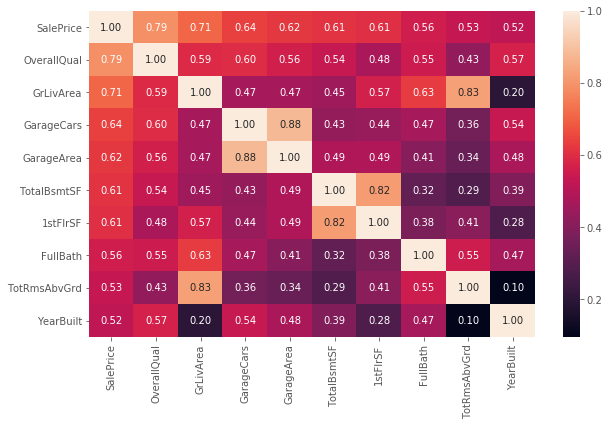

In [16]:
#subset the largest correlation in correlation matrix
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index #getting the var names
coef = np.corrcoef(train[cols].values.T)

sns.heatmap(coef, cbar = True, annot = True,fmt = '.2f', yticklabels = cols.values, xticklabels = cols.values )
#correlation of the first 10 highly correlated variables. 

In [17]:
corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [18]:
corrmat.nsmallest(10,'SalePrice', keep ='all')['SalePrice'].index

Index(['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold',
       'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2'],
      dtype='object')

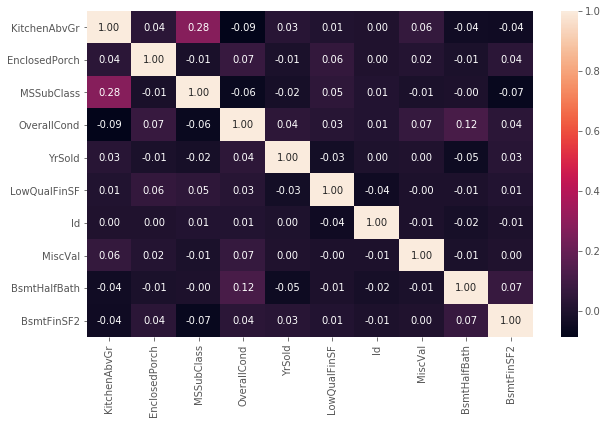

In [19]:
low_corr = corrmat.nsmallest(10,'SalePrice', keep ='all')['SalePrice'].index
coefs = np.corrcoef(train[low_corr].values.T)
sns.heatmap(coefs, cbar = True, annot = True,fmt = '.2f', yticklabels = low_corr.values, xticklabels = low_corr.values )

In [20]:
numeric_var = train.select_dtypes(include = [np.number])
corr = numeric_var.corr()
top_five = corr['SalePrice'].sort_values(ascending = False)[:5]
print(top_five) #sort descending correlation for 
#top 5 correlation
print('*'*30)
tail_five = corr['SalePrice'].sort_values(ascending = False)[-5:]
print(tail_five) #bottom 5 correlation

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64
******************************
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


### Feature Engineering

#### OverallQual

In [21]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

so overall quality is rank from 1 to 10.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

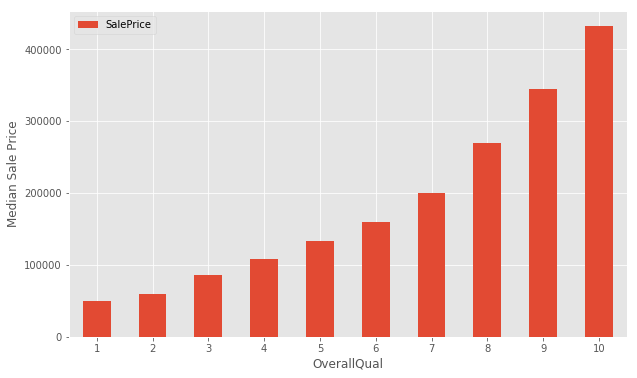

In [22]:
qual_pivot = train.pivot_table(index = 'OverallQual', values = 'SalePrice', aggfunc = np.median)
qual_pivot.plot(kind = 'bar') #relatioship between the two vars
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)

GrLivArea      0.708624 <br/>
GarageCars     0.640409 <br/>
GarageArea     0.623431 <br/>


Text(0, 0.5, 'Above grade (ground) living area ')

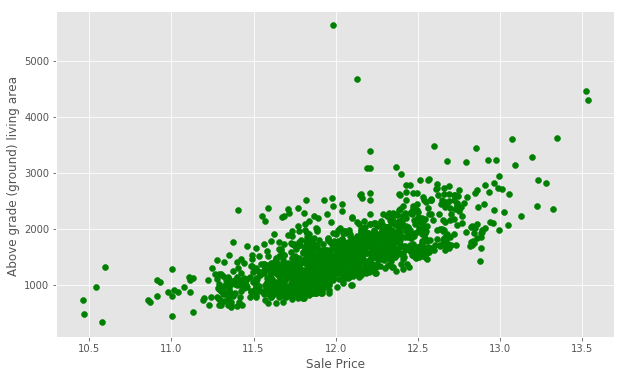

In [23]:
plt.scatter(x = target, y = train['GrLivArea'], c = 'green')
plt.xlabel ( 'Sale Price')
plt.ylabel('Above grade (ground) living area ')

there are 2 outliers > 4000 for living area and lower than 13.5 for sale price

In [24]:
#remove outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 700000)].index)

In [25]:
target = np.log(train['SalePrice'])

Text(0, 0.5, 'Above grade (ground) living area ')

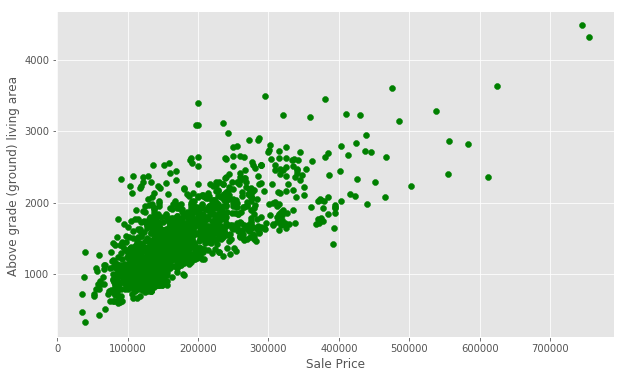

In [26]:
plt.scatter(x = train.SalePrice, y = train['GrLivArea'], c = 'green')
plt.xlabel ( 'Sale Price')
plt.ylabel('Above grade (ground) living area ')

Text(0, 0.5, 'Garage Area')

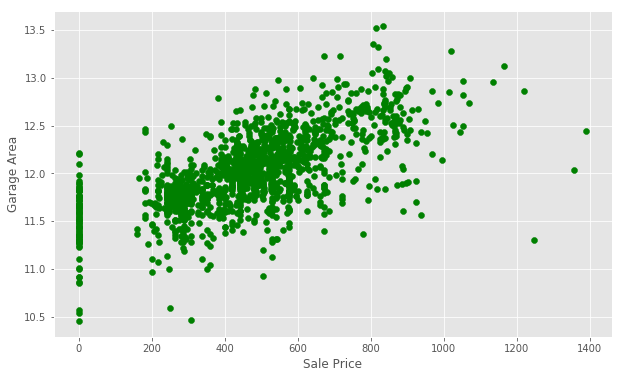

In [27]:
plt.scatter(y = target, x = train['GarageArea'], c = 'green')
plt.xlabel('Sale Price')
plt.ylabel('Garage Area')


they both have linear relationships. <br/>


Homoscedasticity: refers to the assumption that dependent varibales exhibit equal levels of variance across the range of predictor  variables.

Text(0, 0.5, 'Total basement squarefoot')

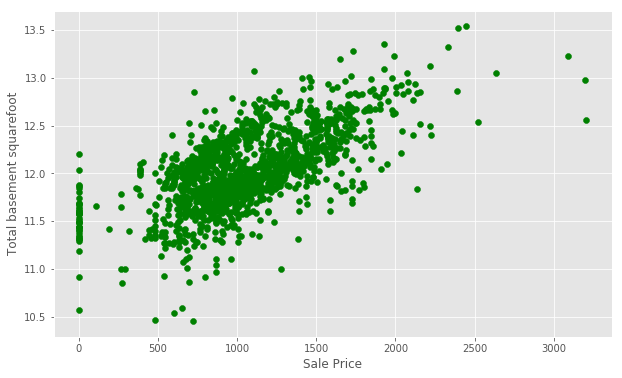

In [28]:
plt.scatter(y = target, x = train['TotalBsmtSF'], c = 'green')
plt.xlabel('Sale Price')
plt.ylabel('Total basement squarefoot')

Which outliers to remove? 


### Concatenate

In [29]:
train_n = train.shape[0] #number of rows to split later
test_n = test.shape[0]

In [30]:

all_data = pd.concat([train, test]).reset_index(drop = True)
print(all_data.shape)

(2917, 81)


C:\Users\trang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [31]:
all_data.drop(['SalePrice'], axis = 1, inplace = True) #remove target var

In [32]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [33]:
null_percent = (all_data.isnull().sum() / len(all_data))*100
null_percent = null_percent[null_percent.sort_values(ascending = False) >0].sort_values(ascending = False)
missing_ratio = pd.DataFrame(null_percent)
missing_ratio.columns = ['Missing Ratio']
missing_ratio

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [34]:
missing_ratio.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Utilities', 'Functional', 'Electrical', 'BsmtUnfSF', 'Exterior1st',
       'Exterior2nd', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF2',
       'BsmtFinSF1', 'KitchenQual', 'SaleType'],
      dtype='object')

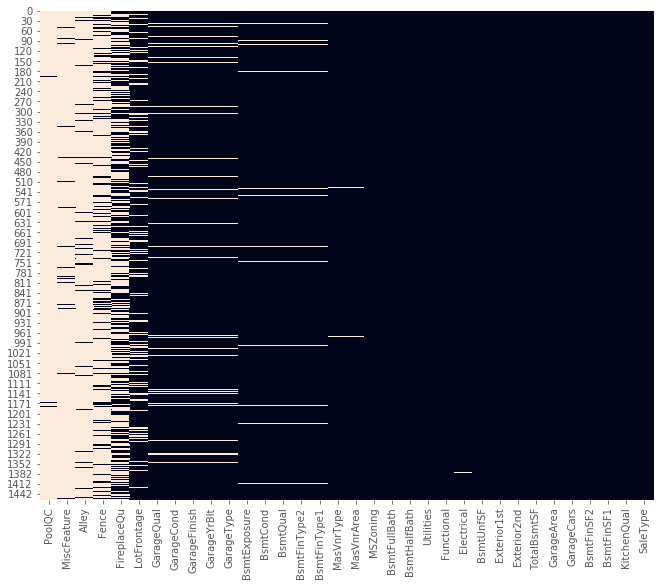

In [35]:
#visualize missing data combinations: 
fig, ax  = plt.subplots(figsize = (11, 9))
sns.heatmap(train.loc[:,['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Utilities', 'Functional', 'Electrical', 'BsmtUnfSF', 'Exterior1st',
       'Exterior2nd', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF2',
       'BsmtFinSF1', 'KitchenQual', 'SaleType']].isnull(), cbar = False, ax = ax)

Missing Completely at random: the columns with only one or no white bar . 
Missing at random: basement - because chance of missing is dependent on variables with complete info in the dataset. 
Missing not at random: means none. 

In [36]:
#create dataframe with all data
all_data_original = all_data.copy()

### Imputing missing values <br/>


#### PoolQC
for PoolQC, there are 99% and majority of houses have no pool at all in general <br/>
So we should just put none 

In [37]:
all_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [38]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [39]:
all_data['PoolQC'].value_counts()

None    2908
Ex         4
Gd         3
Fa         2
Name: PoolQC, dtype: int64

### MiscFeature

In [40]:
all_data['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [41]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [42]:
all_data['MiscFeature'].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

### Alley

In [43]:
all_data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [44]:
all_data['Alley'] = all_data['Alley'].fillna('None')

In [45]:
all_data['Alley'].unique()

array(['None', 'Grvl', 'Pave'], dtype=object)

### Fence

In [46]:
all_data['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [47]:
all_data['Fence'] = all_data['Fence'].fillna('None')

### FirePlaceQu

In [48]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [49]:
all_data['FireplaceQu'].unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

### LotFrontage

In [50]:
all_data['LotFrontage'].median()

68.0

Linear feet of street connected to property: The area of each street connected to the house likely to have simmilar area to other houses in the neighbor hood. So we can fill in missing values by the median LotFrontage of each neighborhood.


In [51]:
#fill NAs with median values of each neighborhood LotFrontage
all_data['LotFrontage'] = all_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [52]:
all_data['LotFrontage'].unique()

array([ 65. ,  80. ,  68. ,  60. ,  84. ,  85. ,  75. ,  51. ,  50. ,
        70. ,  72. ,  91. ,  73. ,  66. , 101. ,  57. ,  44. , 110. ,
        98. ,  47. , 108. , 112. ,  74. , 115. ,  67. ,  61. ,  48. ,
        33. ,  64. ,  52. , 100. ,  24. ,  89. ,  63. ,  76. ,  81. ,
        95. ,  69. ,  21. ,  32. ,  78. , 121. , 122. ,  40. , 105. ,
        77. ,  94. ,  34. ,  90. ,  80.5,  55. ,  88. ,  82. ,  71. ,
       120. , 107. ,  92. , 134. ,  62. ,  86. , 141. ,  97. ,  72.5,
        54. ,  41. ,  79. , 174. ,  99. ,  83. ,  43. , 103. ,  93. ,
        30. ,  64.5, 129. , 140. ,  35. ,  37. , 118. ,  87. , 116. ,
       150. , 111. ,  49. ,  96. ,  59. ,  36. ,  56. , 102. ,  58. ,
        38. , 109. , 130. ,  53. , 137. ,  45. , 106. , 104. ,  42. ,
        39. , 144. , 114. , 128. , 149. , 313. , 168. , 182. , 138. ,
       160. , 152. , 124. , 153. ,  46. ,  26. ,  25. , 119. ,  31. ,
        28. , 117. , 113. , 125. , 135. , 136. ,  22. , 123. , 195. ,
       155. , 126. ,

GarageQual	5.450806
GarageCond	5.450806
GarageFinish	5.450806
GarageYrBlt	5.450806
GarageType	5.382242

### Garage
None for Garage Type, Garage Condition, Garage Finish, and garage quality (object type)

In [53]:
all_data['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [54]:
for col in ('GarageType', 'GarageCond', 'GarageFinish', 'GarageQual'):
    all_data[col] = all_data[col].fillna('None')

for garage year built, garage area and garage cars: replace with 0 


In [55]:
all_data['GarageYrBlt'].value_counts(dropna = False)

NaN       159
2005.0    142
2006.0    115
2007.0    114
2004.0     99
2003.0     92
1977.0     66
2008.0     60
1998.0     58
2000.0     55
1999.0     54
2002.0     53
1950.0     51
1976.0     50
1993.0     49
1968.0     48
1997.0     44
1958.0     42
1956.0     41
1978.0     41
2001.0     41
1996.0     40
1994.0     39
1966.0     39
1954.0     37
1960.0     37
1967.0     36
1959.0     36
1964.0     35
1974.0     35
         ... 
1922.0      8
1935.0      8
1924.0      8
1915.0      7
1928.0      7
1936.0      7
1937.0      6
1900.0      6
1916.0      6
1923.0      6
1942.0      6
1947.0      5
2010.0      5
1927.0      5
1921.0      5
1931.0      4
1932.0      4
1934.0      4
1918.0      3
1917.0      2
1914.0      2
1929.0      2
1943.0      1
1908.0      1
1895.0      1
1933.0      1
1919.0      1
1896.0      1
2207.0      1
1906.0      1
Name: GarageYrBlt, Length: 104, dtype: int64

In [56]:
for col in ('GarageCars', 'GarageArea', 'GarageYrBlt'):
    all_data[col]= all_data[col].fillna(0)

In [57]:
all_data['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,    0., 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933., 1917.,
       1896., 1895., 2207., 1943., 1919.])

In [58]:
missing_ratio

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


### Basement


BsmtExposure: Refers to walkout or garden level wall
BsmtCond: Evaluates the general condition of the basement
BsmtQual: Evaluates the height of the basement
BsmtExposure	2.811107
BsmtCond	2.811107
BsmtQual	2.776826
BsmtFinType2	2.742544
BsmtFinType1	2.708262
BsmtUnfSF	0.034282
TotalBsmtSF	0.034282
BsmtFinSF2	0.034282
BsmtFinSF1	0.034282

In [59]:
all_data.select_dtypes(include = ['float64']).columns

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea',
       'TotalBsmtSF'],
      dtype='object')

In [60]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 
            'BsmtHalfBath', 'BsmtUnfSF','TotalBsmtSF' ):
    all_data[col] = all_data[col].fillna(0)

In [61]:
for col in ('BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual' ):
    all_data[col] = all_data[col].fillna('None')

### Masonry Veneer Type

In [62]:
type(all_data['MasVnrArea'][0])
type(all_data['MasVnrType'][0])

str

In [63]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

In [64]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

### MSZoning: 
identifies the general zoning classification of the sale

In [65]:
type(all_data['MSZoning'][0])

str

In [66]:
all_data['MSZoning'].describe()

count     2913
unique       5
top         RL
freq      2263
Name: MSZoning, dtype: object

So we should fill it with RL which is the mode

In [67]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

### Utilities

In [68]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

We can remove this. 

In [69]:
all_data = all_data.drop(['Utilities'], axis = 1)

Functional	0.068564
Electrical	0.034282
BsmtUnfSF	0.034282
Exterior1st	0.034282
Exterior2nd	0.034282
TotalBsmtSF	0.034282
GarageArea	0.034282
GarageCars	0.034282
BsmtFinSF2	0.034282
BsmtFinSF1	0.034282
KitchenQual	0.034282
SaleType	0.034282

### Functional

In [70]:
all_data['Functional'].value_counts(dropna = False)

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
NaN        2
Name: Functional, dtype: int64

In [71]:
all_data['Functional'].mode()

0    Typ
dtype: object

In [72]:
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])

### Electrical


In [73]:
all_data['Electrical'].value_counts(dropna = False)

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [74]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

### Exterior

In [75]:
all_data['Exterior1st'].value_counts(dropna = False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64

In [76]:
all_data['Exterior2nd'].value_counts(dropna = False)

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: Exterior2nd, dtype: int64

In [77]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])


### Kitchen Quality

In [78]:
all_data['KitchenQual'].value_counts(dropna = False)


TA     1492
Gd     1151
Ex      203
Fa       70
NaN       1
Name: KitchenQual, dtype: int64

In [79]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

### Sale Type

In [80]:
all_data['SaleType'].value_counts(dropna = False)

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
NaN         1
Name: SaleType, dtype: int64

In [81]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [82]:
null_percent = (all_data.isnull().sum() / len(all_data))*100
null_percent = null_percent[null_percent.sort_values(ascending = False) >0].sort_values(ascending = False)
missing_ratio = pd.DataFrame(null_percent)
missing_ratio.columns = ['Missing Ratio']
missing_ratio

,Missing Ratio


In [83]:
#turn ordinal variables into str to be encoded
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold']= all_data['YrSold'].astype(str)
all_data['MoSold']= all_data['MoSold'].astype(str)

In [84]:
all_data[['OverallCond']] 

,OverallCond
0,5
1,8
2,5
3,5
4,5
5,5
6,5
7,6
8,5
9,6


In [85]:
#Label encode categorical ordinal variables
from sklearn.preprocessing import LabelEncoder
ord_feats = ('MSSubClass', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
         'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'LandSlope', 
         'CentralAir', 'PavedDrive','GarageQual', 'GarageCond', 'Street',
         'PoolQC', 'Fence', 'YrSold', 'MoSold', 'LotShape', 'GarageFinish' )

for f in ord_feats:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[f].values))
    all_data[f] = lbl.transform(list(all_data[f].values))

    
print(all_data.shape)


(2917, 79)


In [86]:
#Since area relates featurs are important in real estate prices, we can add totalSF
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] +all_data['2ndFlrSF']

Text(0.5, 1.0, 'Top 10 highly skewed features')

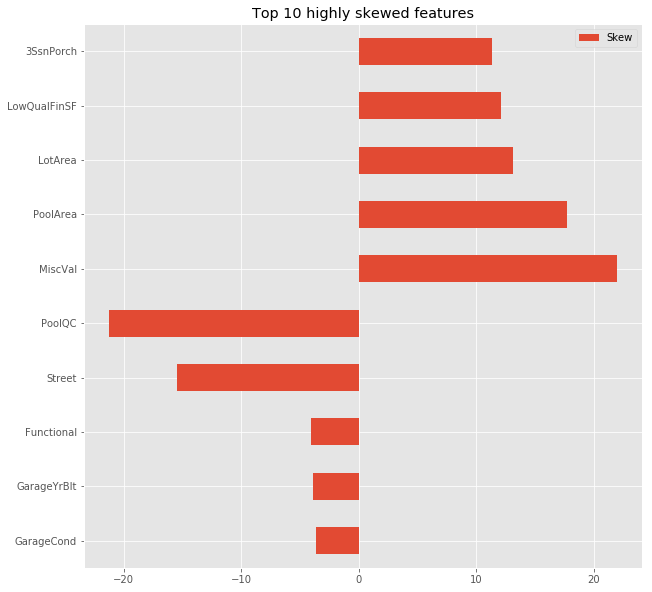

In [87]:
#finding skewness in numerical featuresd:
numerics = all_data.select_dtypes(include = [np.number]).columns
skewed_feats = pd.DataFrame(all_data[numerics].skew().sort_values(ascending = False))
matplotlib.rcParams['figure.figsize'] = (10, 10)
#skewed_feats = skewed_feats.reset_index()
skewed_feats.columns = ['Skew']
#sns.barh(x= skewed_feats['Features'], y = skewed_feats['Skew'])
high_skew = pd.concat([skewed_feats.tail(5), 
                           skewed_feats.head(5)])
high_skew.plot(kind = 'barh')
plt.title("Top 10 highly skewed features")

In [88]:
skewed_feats

,Skew
MiscVal,21.950962
PoolArea,17.697766
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
LandSlope,4.975813
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131


##### Skewness affects the regression intercept, coefficients associated with the model.

We are going to Box Cox Transformation highly skewed features

In [89]:
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75] #filtered out high skew

skewed_feats.shape[0]

59

In [90]:
from scipy.special import boxcox1p
skews = skewed_feats.index
lmda = 0.15
for feat in skews:
    all_data[feat] = boxcox1p(all_data[feat], lmda)

### Dummifying categorical features

In [91]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 223)

In [92]:
#get back train and test set
X_train = all_data[:train_n]
X_test = all_data[:test_n]
y = target

In [93]:
all_data.shape

(2917, 223)

 ## Modelling

In [94]:
from sklearn.linear_model import ElasticNet, LassoCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV


In [95]:
#cross validation function:
n_folds = 10
def rmse_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)
    

In [96]:
alphas = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alphas).fit(X_train, y)

C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [97]:
rmse_cv(model_lasso).mean()

C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

0.1115211499011857

In [98]:
coefs = pd.Series(model_lasso.coef_, index = X_train.columns)

In [99]:
str(sum(coef != 0))

'[10 10 10 10 10 10 10 10 10 10]'

In [100]:
str(sum(coefs == 0))
#eliminated 178 varibles

'128'

In [101]:
#filter out important coefficient
filtered_coef = pd.concat([coefs.sort_values().tail(10), 
                           coefs.sort_values().head(10)])

In [102]:
coefs.sort_values().tail(10)

Exterior1st_BrkFace     0.051696
Functional              0.055657
Neighborhood_NoRidge    0.061459
GarageCars              0.068460
Neighborhood_Crawfor    0.076479
CentralAir              0.076482
Neighborhood_StoneBr    0.086159
TotalSF                 0.127559
OverallCond             0.166074
OverallQual             0.252725
dtype: float64

Text(0.5, 1.0, 'Coefficients')

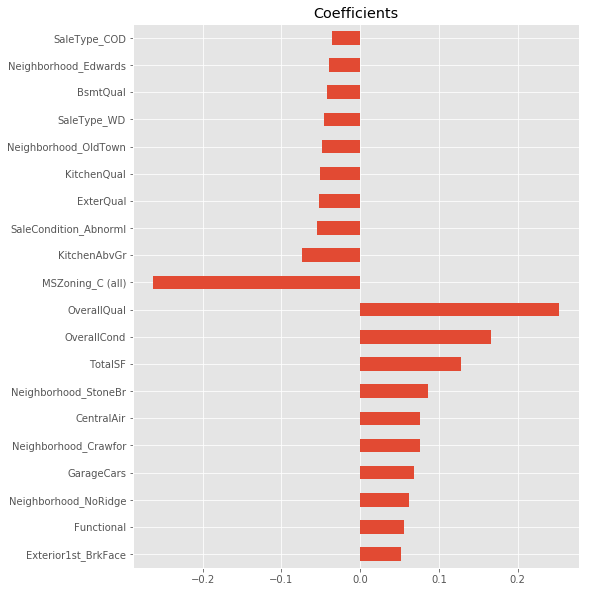

In [103]:
matplotlib.rcParams['figure.figsize'] = (8, 10)
filtered_coef.plot(kind = 'barh')
plt.title("Coefficients")

In [104]:
### trying xgboost
import xgboost as xgb
xg_train = xgb.DMatrix(X_train, label = y)
xg_test = xgb.DMatrix(y)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, xg_train,  num_boost_round=500, early_stopping_rounds=100)


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


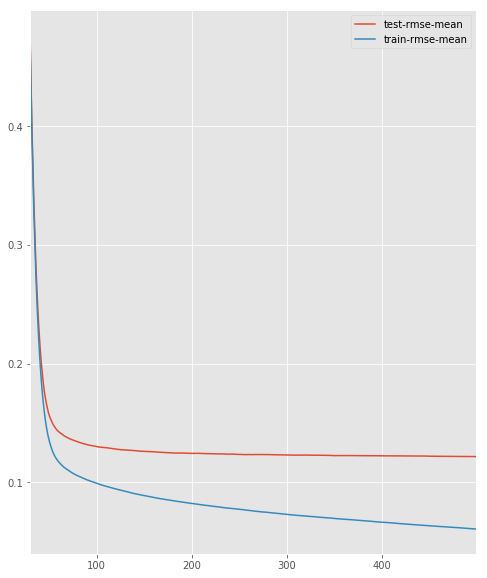

In [105]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [106]:
model_xgb = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
model_xgb.fit(X_train, y)

[16:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [107]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
xgb_preds

array([206587.73, 178777.78, 213891.67, ..., 136999.61, 150762.5 ,
       118429.69], dtype=float32)

In [108]:
rmse_cv(model_xgb).mean()

[16:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\trang\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:30:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1166624769169337

In [109]:
submission = pd.read_csv("sample_submission.csv")
#test data
X_train = all_data.iloc[:train_n,:]
X_test = all_data.iloc[train_n:,:]
y = target
reg = LassoCV(alphas = alphas).fit(X_train, y)
reg.score(X_train,y)
y_estimated = np.exp(reg.predict(X_test))-1
submission['SalePrice'] = y_estimated
submission.to_csv("submission.csv", index=False)

C:\Users\trang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
